In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!pip install wfdb
!pip install mne
!pip install nitime
!pip install nolds

In [3]:

!pip install git+https://github.com/forrestbao/pyeeg.git
!pip install git+https://github.com/raphaelvallat/entropy.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-4ilc4nw3
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-4ilc4nw3
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28121 sha256=7c0071c448b6c4ce46e88a32b0816e9df8f1d8720777465c5e9afa1db9d7be1d
  Stored in directory: /tmp/pip-ephem-wheel-cache-1kaawrhq/wheels/2d/3f/ad/106d4fc80b61d1ea1fc18e76e7439fd98aa043d83d58eae741
Successfully built pyeeg
  Cloning https://github.com/raphaelvallat/entropy.git to /tmp/pip-req-build-mr9eiyr4
  Running command git clone -q https://github.com/raphaelvallat/entropy.git /tmp/pip-req-build-mr9eiyr4
  Created wheel for entropy: filename=entropy-0.1.0-cp36-none-any.whl size=14098 sha256=78343b1666fa7e23bb8aeadc5e109a687a6c975d5d74ed6c01453322b0f662f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-fypsywfh/wheels/60/ed/d3/b715e38438f1f39edb1383aea79c578073953b25fa576fc71e
Successfully built entropy


In [4]:
cd /content/drive/My Drive/dataset/schizophrenia16

/content/drive/My Drive/dataset/schizophrenia16


In [0]:
import numpy as np
from glob import glob

In [0]:
import pickle
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [0]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Analyse a sample data

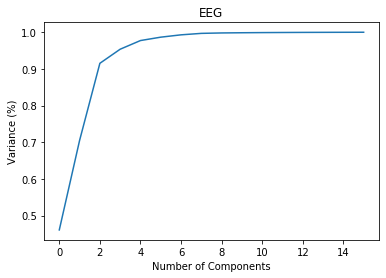

(6, 7680)


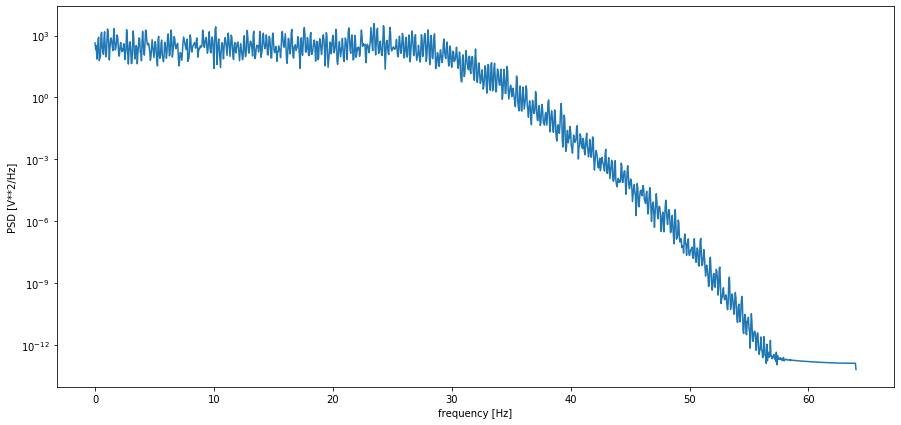

In [9]:
data=np.loadtxt('sch/088w1.eea')
from scipy import signal
nyq = 0.5 * 128
low = 0.1 / nyq
high = 30/ nyq
fs=128
#low freq =0.1
win = 2/0.1 * fs
b, a = signal.butter(5, [low,high], 'band')
data=data.reshape(-1,16).T #datapoints x columns
    # Tranpose is taken becz data should be columns into sample points
data=signal.detrend(data)
data=signal.filtfilt(b, a, data)  

pca = PCA().fit(data.T)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('EEG')
plt.show()

pca=PCA(6)
data=pca.fit_transform(data.T).T
print(data.shape)
plt.figure(figsize=(15,7))
f, Pxx_den = signal.welch(data,fs,nperseg=win )
plt.semilogy(f,Pxx_den[5])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()



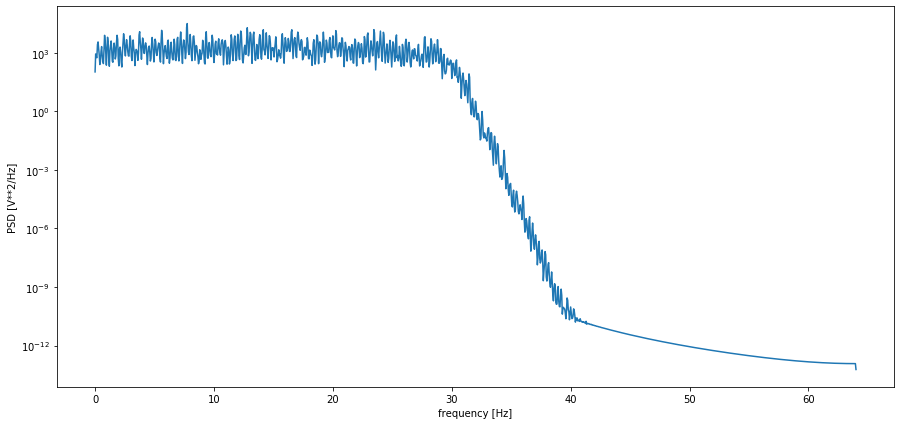

In [10]:
data=np.loadtxt('norm/S10W1.eea')
from scipy import signal
nyq = 0.5 * 128
low = 0.1 / nyq
high = 30 / nyq
b, a = signal.butter(16, high, 'low')
data=data.reshape(-1,16).T #datapoints x columns
    # Tranpose is taken becz data should be columns into sample points
data=signal.detrend(data)
data=signal.filtfilt(b, a, data)  
fs=128
#low freq =0.1
win = 2/0.1 * fs

plt.figure(figsize=(15,7))
f, Pxx_den = signal.welch(data,fs,nperseg=win )
plt.semilogy(f,Pxx_den[0])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()



# Read Data

In [0]:
HC_path=glob('norm/*.eea')
SZ_path=glob('sch/*.eea')

In [0]:
nyq = 0.5 * 128
low = 0.1 / nyq
high = 30/ nyq
fs=128

In [0]:
HC=[]#trialxsample x channels
for i in HC_path:
    data=np.loadtxt(i)
    data=data.reshape(-1,16).T #datapoints x columns
    # Tranpose is taken becz data should be columns into sample points
    data=signal.filtfilt(b, a, data) 
    data=pca.fit_transform(data.T).T
    data=data.reshape(6,-1,512).T
    data=np.swapaxes(data,0,1)
    HC.append(data)


In [0]:
SZ=[]
for i in SZ_path:
    data=np.loadtxt(i)
    data=data.reshape(-1,16).T #datapoints x columns
    # Tranpose is taken becz data should be columns into sample points
    data=pca.fit_transform(data.T).T
    data=data.reshape(6,-1,512).T
    data=np.swapaxes(data,0,1)
    SZ.append(data)

In [17]:
HC[0].shape,SZ[0].shape

((15, 512, 6), (15, 512, 6))

# Feature Calculation

In [0]:
from scipy import stats
import pyeeg
from entropy import *
def mean(data):
    return np.mean(data,axis=0)
    
def std(data):
    return np.std(data,axis=0)

def ptp(data):
    return np.ptp(data,axis=0)

def var(data):
        return np.var(data,axis=0)

def minim(data):
      return np.min(data,axis=0)


def maxim(data):
      return np.max(data,axis=0)


def mean_square(data):
      return np.mean(data**2,axis=0)

def rms(data): #root mean square
      return  np.sqrt(np.mean(data**2,axis=0))  

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)


def skewness(data):
    return stats.skew(data,axis=0)

def kurtosis(data):
    return stats.kurtosis(data,axis=0)

def zero_crossing(data):
    return np.argmax(np.diff(np.sign(data),axis=0),axis=0)

def app_epy(data):
    result=[]
    for i in data.T:
        result.append(app_entropy(i, order=2, metric='chebyshev'))
    return np.array(result)

def perm_epy(data):
    result=[]
    for i in data.T:
        result.append(perm_entropy(i, order=3, normalize=True))
    return np.array(result)

def svd_epy(data):
    result=[]
    for i in data.T:
        result.append(svd_entropy(i, order=3, delay=1, normalize=True))
    return np.array(result)

def spectral_epy(data):
    result=[]
    for i in data.T:
        result.append(spectral_entropy(i, 100, method='welch', normalize=True))
    return np.array(result)

def sample_epy(data):
    result=[]
    for i in data.T:
        result.append(sample_entropy(i, order=2, metric='chebyshev'))
    return np.array(result)


def katz(data):
    result=[]
    for i in data.T:
        result.append(katz_fd(i))
    return np.array(result)

def higuchi(data):
    result=[]
    for i in data.T:
        result.append(higuchi_fd(i))
    return np.array(result)


def petrosian(data):
    result=[]
    for i in data.T:
        result.append(petrosian_fd(i))
    return np.array(result)

def autogressiveModelParameters(data):
    feature = []
    for i in data.T:
        coeff, sig = alg.AR_est_YW(i, order=5)
        feature.append(np.mean(coeff))
    return np.array(feature)

def teager(x):
    for i in range(len(x)-1):
        return x[i]**2 - (x[i-1]*x[i+1])


        
def hjorth_mobility(data):
    return np.divide(np.std(np.diff(data,axis=0),axis=0),np.std(data,axis=0))

def hjorth_complexity(data):
    return np.divide(hjorth_mobility(np.diff(data,axis=0)),  hjorth_mobility(data))      




def concatenate_features(data):
    return np.concatenate((mean(data),std(data),ptp(data),var(data),minim(data),maxim(data),
                          mean_square(data),rms(data),abs_diffs_signal(data),
                          skewness(data),kurtosis(data),zero_crossing(data),
                          app_epy(data),perm_epy(data),svd_epy(data),spectral_epy(data),sample_epy(data),
                          katz(data),higuchi(data),petrosian(data),
                          hjorth_mobility(data),hjorth_complexity(data)),axis=0)

In [0]:
features1=[]
for f in HC:
    feature=[]
    for i in f:
        feature.append(concatenate_features(i))
    features1.append(np.mean(np.array(feature),axis=0))
    

In [0]:

features2=[]
for f in SZ:
    feature=[]
    for i in f:
        feature.append(concatenate_features(i))
    features2.append(np.mean(np.array(feature),axis=0))

In [0]:
x1=np.array(features1)        
x2=np.array(features2)      

X_all=np.concatenate((x1,x2),axis=0)
y_all=np.concatenate(((np.zeros(x1.shape[0])),(np.ones(x2.shape[0]))))


In [22]:
X_all.shape[1]


132

# Classification

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all,test_size=0.3, random_state=42,stratify=y_all)

In [0]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [25]:
clf=LogisticRegression()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report,accuracy_score
print(classification_report(y_test,y_pred))
print('accuracy is ',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12
         1.0       1.00      1.00      1.00        14

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26

accuracy is  1.0


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Feature Selection

In [0]:
feature_list=['mean','std','ptp','var','minim','maxim','mean_square','rms','abs_diffs_signal','skewness','kurtosis','zero_crossing',
'app_epy','perm_epy','svd_epy','spectral_epy','sample_epy','katz','higuchi','petrosian','hjorth_mobility','hjorth_complexity']

In [0]:
classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="rbf"),
    AdaBoostClassifier(),
    LogisticRegression()]

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
clf_feature_selected=[]
for clf in classifiers:
    feature_selected=[]
    for i in range(81):
        randomize = np.arange(len(X_all))
        np.random.shuffle(randomize)
        X_all = X_all[randomize]
        y_all = y_all[randomize]
        for i,j in zip(range(0,X_all.shape[1],16),feature_list):
            X_new=X_all[:,i:i+16]
            y_new=y_all.copy()
            X_train, X_test, y_train, y_test = train_test_split(X_new, y_all,test_size=0.2, random_state=42,stratify=y_all)
            sc=StandardScaler()
            X_train=sc.fit_transform(X_train)
            X_test=sc.transform(X_test)

            clf.fit(X_train,y_train)
            y_pred = clf.predict(X_test)  
            acc=metrics.accuracy_score(y_test, y_pred)
      #print("Accuracy of ",j,metrics.accuracy_score(y_test, y_pred))
            if acc>0.75:
                feature_selected.append(j)
    clf_feature_selected.append(feature_selected)        
 # print('-------------------------------------------------------------------')

In [29]:

clf_list=['KNN','SVM','ABC','LR']
from collections import Counter
clf_count=[]
for i,j in zip(range(4),clf_list):
    feature_selected=clf_feature_selected[i]
    count= {x:feature_selected.count(x) for x in feature_selected}
    c = Counter(count)
    #print(c.most_common())
    #clf_count.append(c.most_common(10))
    print('==================================================================================================')
    print(j,c.most_common(10))

KNN [('var', 81), ('minim', 81), ('maxim', 81), ('mean_square', 81), ('rms', 81), ('abs_diffs_signal', 81), ('mean', 73), ('ptp', 72), ('std', 70)]
SVM [('var', 81), ('minim', 81), ('maxim', 81), ('mean_square', 81), ('rms', 81), ('abs_diffs_signal', 81), ('mean', 79), ('ptp', 79), ('std', 75)]
ABC [('mean', 81), ('var', 81), ('minim', 81), ('maxim', 81), ('mean_square', 81), ('rms', 81), ('std', 80), ('abs_diffs_signal', 80), ('ptp', 78)]
LR [('var', 81), ('minim', 81), ('maxim', 81), ('mean_square', 81), ('rms', 81), ('abs_diffs_signal', 81), ('mean', 80), ('std', 80), ('ptp', 80)]


In [0]:
#{k: v / total for total in (sum(c.values(), 0.0),) for k, v in c.items()}


In [0]:
from collections import Counter
clf_feature=[]
for i in range(4):
    feature_selected=clf_feature_selected[i]
    count= {x:feature_selected.count(x) for x in feature_selected}
    c = Counter(count)
    #c={k: v / total for total in (sum(c.values(), 0.0),) for k, v in c.items()}

    for k,v in c.items():
        if v>10:
            clf_feature.append(k)

In [31]:

count= {x:clf_feature.count(x) for x in clf_feature}
c = Counter(count)
print(c.most_common())
good_feature=[]
for i in range(len(c.keys())):
      good_feature.append(c.most_common()[i][0])
print('===============================================================================================================')
print(good_feature)

[('mean', 4), ('std', 4), ('ptp', 4), ('var', 4), ('minim', 4), ('maxim', 4), ('mean_square', 4), ('rms', 4), ('abs_diffs_signal', 4)]
['mean', 'std', 'ptp', 'var', 'minim', 'maxim', 'mean_square', 'rms', 'abs_diffs_signal']


In [0]:
#good_feature=['ptp','sample_epy']


In [32]:
X_good=[]
for key,val in zip(feature_list,range(0,X_all.shape[1],16)):
    for fe in good_feature:
        if key==fe:     
            print('key',key,'value',val,":",val+16) 
            X_good.append(X_all[:,val:val+16])

key mean value 0 : 16
key std value 16 : 32
key ptp value 32 : 48
key var value 48 : 64
key minim value 64 : 80
key maxim value 80 : 96
key mean_square value 96 : 112
key rms value 112 : 128
key abs_diffs_signal value 128 : 144


In [0]:
X=np.concatenate((X_good),axis=1)
y=y_all.copy()
#X=X_all.copy()

In [0]:
from sklearn.neural_network import MLPClassifier as MLP
clf=MLP(hidden_layer_sizes=(20,),alpha=0.001, max_iter=1000,learning_rate ='adaptive')

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42,stratify=y_all)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
#clf=LogisticRegression()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report,accuracy_score
print(classification_report(y_test,y_pred))
print('accuracy is ',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         8
         1.0       1.00      1.00      1.00         9

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17

accuracy is  1.0


# Fine tuning 

In [0]:
X=X_all.copy()
y=y_all.copy()

## SVM

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

clf = SVC(kernel="rbf")
Cs = [ 1,2,3,5,7,10,15,30,50,70,100]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__C=Cs,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

1.0


{'classifier__C': 1, 'classifier__gamma': 0.001}

## KNN

In [38]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()

n_neighbors  = [ 3,4,5,6,7,8,9,10,11]
weights  = ['uniform','distance']
metric=['minkowski','manhattan','euclidean']
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__n_neighbors=n_neighbors,classifier__weights=weights,classifier__metric=metric),cv=5,n_jobs=-1,iid=False) 
results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

1.0


{'classifier__metric': 'minkowski',
 'classifier__n_neighbors': 3,
 'classifier__weights': 'uniform'}

## nuSVM

In [39]:

from sklearn.svm import SVC, LinearSVC, NuSVC

clf = NuSVC(kernel="rbf")
nu = [0.1,0.3,0.5,0.7]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__nu=nu,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

1.0


{'classifier__gamma': 0.001, 'classifier__nu': 0.1}

## LR

In [40]:
clf = LogisticRegression()
C = [ 1,2,3,5,7,10,15,30,50,70,100]
penalty=["l1","l2"]
pipe = Pipeline(steps=[('scaler', sc), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(classifier__C=C,classifier__penalty=penalty),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

1.0


{'classifier__C': 1, 'classifier__penalty': 'l1'}

# Cross Validation 

In [0]:
classifiers = [
    KNeighborsClassifier(n_neighbors=5,weights='uniform',metric='minkowski'),
    SVC(kernel="rbf",C=3,gamma=0.03),
    NuSVC(nu=0.5,gamma=0.03),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(C=50,penalty='l1')]

In [42]:
pipeline = Pipeline([('transformer', sc),('estimator', clf)])
accuracy=[]
accuracy_std=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy.append(np.array(scores).mean())
    accuracy_std.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())

KNeighborsClassifier
****Results****
Accuracy: 100.0000%
SVC
****Results****
Accuracy: 95.2941%
NuSVC
****Results****
Accuracy: 94.1176%
DecisionTreeClassifier
****Results****
Accuracy: 100.0000%
RandomForestClassifier
****Results****
Accuracy: 100.0000%
AdaBoostClassifier
****Results****
Accuracy: 100.0000%
GradientBoostingClassifier
****Results****
Accuracy: 100.0000%
GaussianNB
****Results****
Accuracy: 100.0000%
LinearDiscriminantAnalysis
****Results****
Accuracy: 100.0000%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 92.9412%
LogisticRegression
****Results****
Accuracy: 100.0000%


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/d

Text(0.5, 1.0, 'Classifiers')

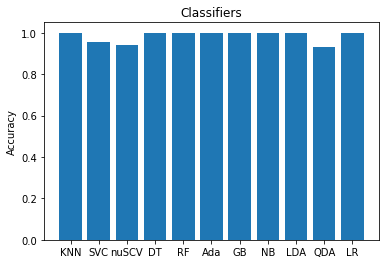

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
classifier=['KNN','SVC','nuSCV','DT','RF','Ada','GB','NB','LDA','QDA','LR']
y_pos = np.arange(len(classifier))
plt.bar(y_pos,np.array(accuracy))
plt.xticks(y_pos, classifier)
plt.ylabel('Accuracy')
plt.title('Classifiers')

# Principle Component Analysis

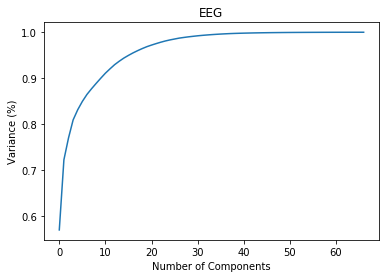

In [44]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score

#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_train)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('EEG')
plt.show()

In [0]:
clf = SVC(kernel='rbf')
pca = PCA(n_components=5)

pipeline = Pipeline([('transformer', sc),('selector',pca), ('estimator', clf)])

In [46]:
accuracy_pca=[]
std_pca=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_pca.append(np.array(scores).mean())
    std_pca.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())

KNeighborsClassifier
****Results****
Accuracy: 100.0000%
SVC
****Results****
Accuracy: 100.0000%
NuSVC
****Results****
Accuracy: 100.0000%
DecisionTreeClassifier
****Results****
Accuracy: 100.0000%
RandomForestClassifier
****Results****
Accuracy: 100.0000%
AdaBoostClassifier
****Results****
Accuracy: 100.0000%
GradientBoostingClassifier
****Results****
Accuracy: 100.0000%
GaussianNB
****Results****
Accuracy: 100.0000%
LinearDiscriminantAnalysis
****Results****
Accuracy: 100.0000%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 100.0000%
LogisticRegression
****Results****
Accuracy: 100.0000%


In [47]:
from sklearn.model_selection import GridSearchCV

clf = SVC(kernel="rbf")
n_components = [5,10,15,20]
Cs = [0.0001,0.001,0.1, 1,2,3,5,7,10,15,30]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
pipe = Pipeline(steps=[('scalar',sc),('selector', pca), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(selector__n_components=n_components,
                              classifier__C=Cs,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

1.0


{'classifier__C': 0.1, 'classifier__gamma': 0.001, 'selector__n_components': 5}

In [48]:
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression()
C = [ 1,2,3,5,7,10,15,30,50,70,100]
penalty=["l1","l2"]
pipe = Pipeline(steps=[('scaler', sc),('selector', pca), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(selector__n_components=n_components,
                             classifier__C=C,classifier__penalty=penalty),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

1.0


{'classifier__C': 1, 'classifier__penalty': 'l1', 'selector__n_components': 5}

# Recursive Feature Elimination

In [0]:
from sklearn.feature_selection import RFE

In [0]:
clf = SVC(kernel='rbf')
rfe=RFE(SVC(kernel='linear'),n_features_to_select=20,step=10,verbose=0)   

pipeline = Pipeline([('transformer', sc),('selector',rfe), ('estimator', clf)])

In [51]:
accuracy_rfe=[]
std_rfe=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_rfe.append(np.array(scores).mean())
    std_rfe.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())

KNeighborsClassifier
****Results****
Accuracy: 100.0000%
SVC
****Results****
Accuracy: 100.0000%
NuSVC
****Results****
Accuracy: 100.0000%
DecisionTreeClassifier
****Results****
Accuracy: 100.0000%
RandomForestClassifier
****Results****
Accuracy: 100.0000%
AdaBoostClassifier
****Results****
Accuracy: 100.0000%
GradientBoostingClassifier
****Results****
Accuracy: 100.0000%
GaussianNB
****Results****
Accuracy: 100.0000%
LinearDiscriminantAnalysis
****Results****
Accuracy: 100.0000%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 100.0000%
LogisticRegression
****Results****
Accuracy: 100.0000%


In [52]:
from sklearn.model_selection import GridSearchCV

clf = SVC(kernel="rbf")
n_features_to_select = [5,10,15,20,25,30]
step=[5,10]
Cs = [0.0001,0.001,0.1, 1,2,3,5,7,10,15,30]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
pipe = Pipeline(steps=[('scalar',sc),('selector', rfe), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(selector__n_features_to_select=n_features_to_select,selector__step=step,
                              classifier__C=Cs,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
print(results.best_score_ )
results.best_params_

1.0


{'classifier__C': 0.1,
 'classifier__gamma': 0.01,
 'selector__n_features_to_select': 5,
 'selector__step': 5}

# SKbest

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [0]:
clf = SVC(kernel='rbf')
skbest=SelectKBest(f_classif, k=5)
pipeline = Pipeline([('transformer', sc),('selector',rfe), ('estimator', clf)])

In [55]:
accuracy_kbest=[]
std_kbest=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_kbest.append(np.array(scores).mean())
    std_kbest.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())

KNeighborsClassifier
****Results****
Accuracy: 100.0000%
SVC
****Results****
Accuracy: 100.0000%
NuSVC
****Results****
Accuracy: 100.0000%
DecisionTreeClassifier
****Results****
Accuracy: 100.0000%
RandomForestClassifier
****Results****
Accuracy: 100.0000%
AdaBoostClassifier
****Results****
Accuracy: 100.0000%
GradientBoostingClassifier
****Results****
Accuracy: 100.0000%
GaussianNB
****Results****
Accuracy: 100.0000%
LinearDiscriminantAnalysis
****Results****
Accuracy: 100.0000%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 100.0000%
LogisticRegression
****Results****
Accuracy: 100.0000%


# VarianceThreshold

In [0]:
from sklearn.feature_selection import VarianceThreshold
clf = SVC(kernel='rbf')
selector = VarianceThreshold(0.1)
pipeline = Pipeline([('transformer', sc),('selector',selector), ('estimator', clf)])

In [57]:
accuracy_var=[]
std_var=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_var.append(np.array(scores).mean())
    std_var.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())

KNeighborsClassifier
****Results****
Accuracy: 100.0000%
SVC
****Results****
Accuracy: 95.2941%
NuSVC
****Results****
Accuracy: 94.1176%
DecisionTreeClassifier
****Results****
Accuracy: 100.0000%
RandomForestClassifier
****Results****
Accuracy: 100.0000%
AdaBoostClassifier
****Results****
Accuracy: 100.0000%
GradientBoostingClassifier
****Results****
Accuracy: 100.0000%
GaussianNB
****Results****
Accuracy: 100.0000%
LinearDiscriminantAnalysis
****Results****
Accuracy: 100.0000%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 92.9412%
LogisticRegression
****Results****
Accuracy: 100.0000%


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/d

# Result

In [0]:

result=pd.DataFrame([accuracy,accuracy_pca,accuracy_rfe,accuracy_kbest,accuracy_var],
                    index=['Accuracy','PCA',"RFE",'kbest','VAR'],
                    columns=['KNN','SVC','nuSCV','DT','RF','Ada','GB','NB','LDA','QDA','LR'])

In [0]:
result=result.T

In [60]:
def _color_red_or_green(val):
    color = 'red' if val < 0.6 else 'green'
    return 'color: %s' % color
result.style.applymap(_color_red_or_green)

,Accuracy,PCA,RFE,kbest,VAR
KNN,1,1,1,1,1
SVC,0.952941,1,1,1,0.952941
nuSCV,0.941176,1,1,1,0.941176
DT,1,1,1,1,1
RF,1,1,1,1,1
Ada,1,1,1,1,1
GB,1,1,1,1,1
NB,1,1,1,1,1
LDA,1,1,1,1,1
QDA,0.929412,1,1,1,0.929412
